In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA,MSTL

pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(20, 16))
plt.rc("font", size=10)

c:\Users\Cesar\AppData\Local\Programs\Python\Python310\lib\site-packages\statsforecast\core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
df = pd.read_csv('C:\\Repo_Pessoal\\Short-Term-Load-Forecasting\\PJME_hourly.csv')
df.columns = ['ds', 'y']
df['ds'] = pd.to_datetime(df['ds'])

# df.set_index('ds', inplace = True)
# df = df.resample('D').mean()
# df.reset_index(inplace=True)

df.insert(0, 'unique_id', 'PJM_Load_hourly')
df = df.sort_values(['unique_id', 'ds']).reset_index(drop=True)
df.head()

,unique_id,ds,y
0,PJM_Load_hourly,2002-01-01 01:00:00,30393.0
1,PJM_Load_hourly,2002-01-01 02:00:00,29265.0
2,PJM_Load_hourly,2002-01-01 03:00:00,28357.0
3,PJM_Load_hourly,2002-01-01 04:00:00,27899.0
4,PJM_Load_hourly,2002-01-01 05:00:00,28057.0


Text(0, 0.5, 'MW')

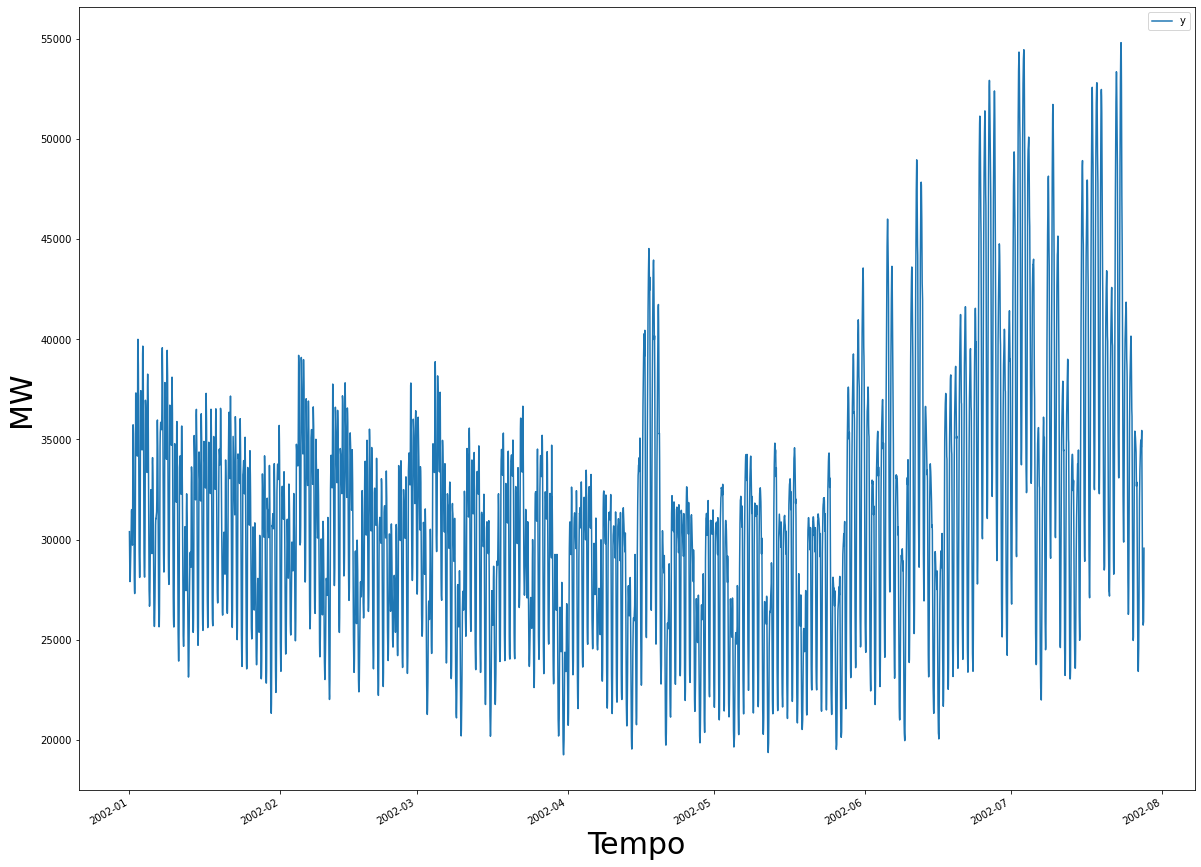

In [3]:
df[0:5000].plot(x='ds', y='y',figsize=(20, 16))
plt.xlabel('Tempo',size=30)
plt.ylabel('MW',size=30)

In [4]:
mstl = MSTL(
    season_length=[24], # seasonalities of the time series 
    trend_forecaster=AutoARIMA(parallel=True,num_cores=3) # model used to forecast trend
)

sf = StatsForecast(
    models=[mstl], # model used to fit each time series 
    freq='H', # frequency of the data
)

sf = sf.fit(df)

c:\Users\Cesar\AppData\Local\Programs\Python\Python310\lib\site-packages\statsforecast\arima.py:1812: UserWarning: Parallel computer is only implemented when stepwise=FALSE, the model will be fit in serial.
  warnings.warn(


In [17]:
ref = sf.fitted_[0, 0].model_.tail(24 * 28)
ref.rename(columns={'trend':'tendencia','seasonal':'sazonalidade','remainder':'ruido'},inplace=True)

C:\Users\Cesar\AppData\Local\Temp\ipykernel_13828\2032029185.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref.rename(columns={'trend':'tendencia','seasonal':'sazonalidade','remainder':'ruido'},inplace=True)


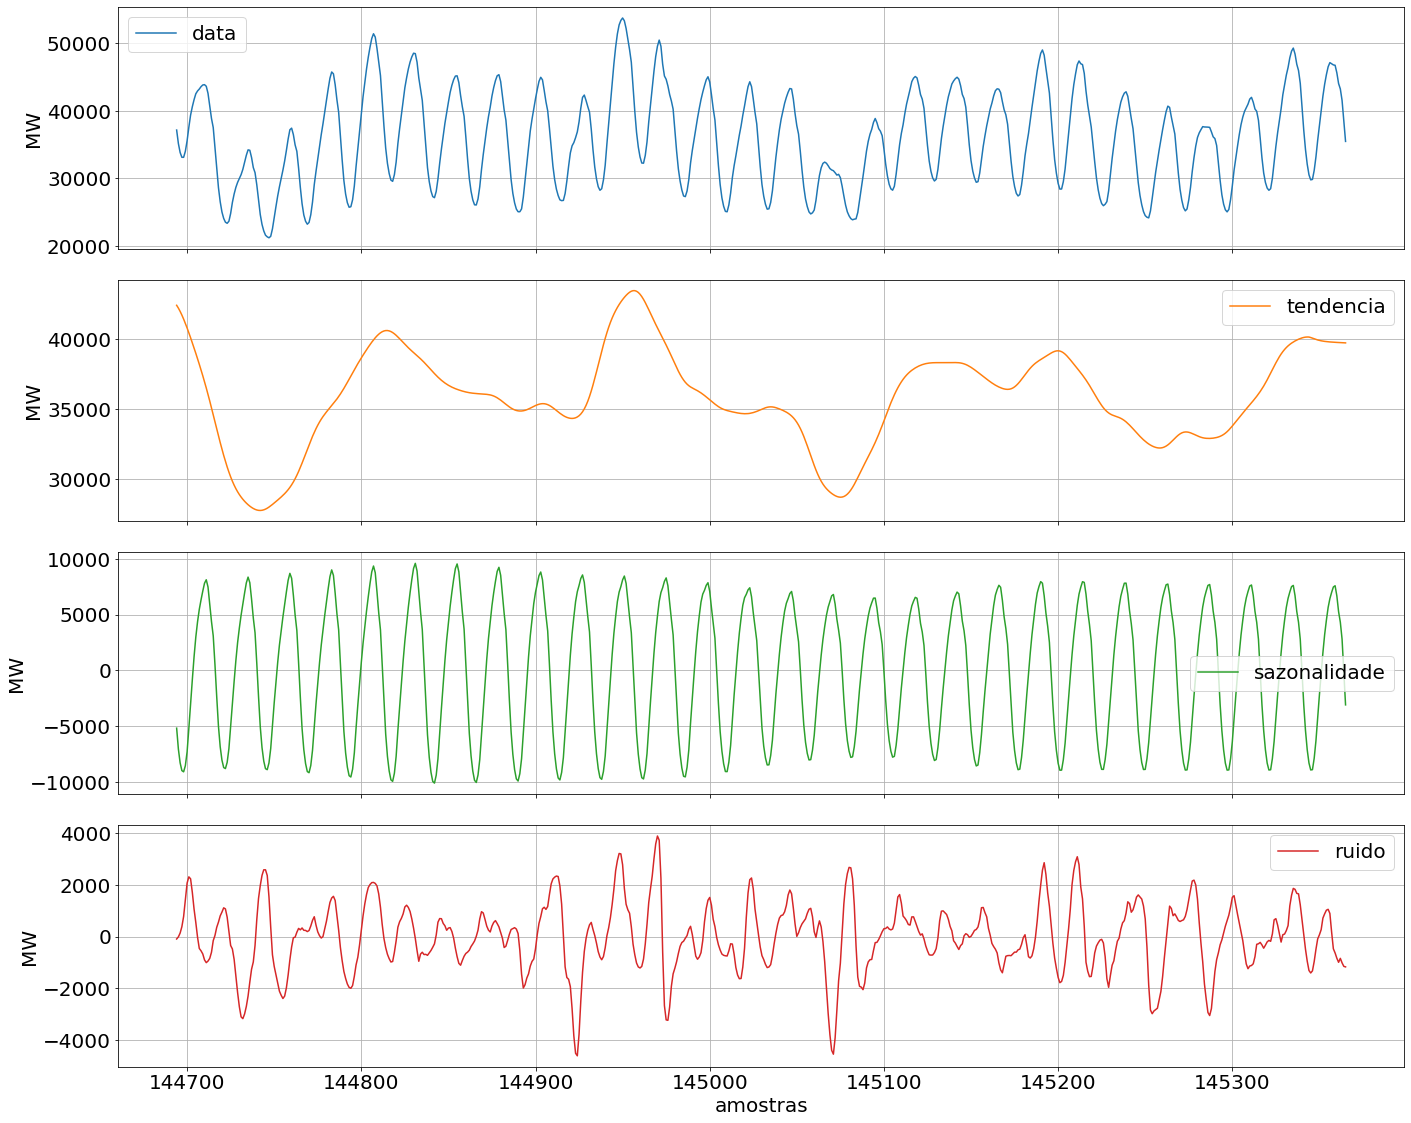

In [16]:
plt.rc("figure", figsize=(20, 16))
plt.rc("font", size=20)
ref.plot(subplots=True, grid=True,xlabel='amostras',ylabel='MW')
# sf.fitted_[0, 0].model_.tail(24 * 28).plot(subplots=True, grid=True,xlabel='amostras',ylabel='MW')
plt.tight_layout()
plt.show()

In [14]:
forecasts = sf.predict(h=31, level=[90])
forecasts.head()

,ds,MSTL,MSTL-lo-90,MSTL-hi-90
unique_id,,,,
PJM_Load_hourly,2018-08-03 01:00:00,32383.949219,32097.798828,32670.099609
PJM_Load_hourly,2018-08-03 02:00:00,30601.000000,30010.136719,31191.861328
PJM_Load_hourly,2018-08-03 03:00:00,29335.716797,28449.982422,30221.453125
PJM_Load_hourly,2018-08-03 04:00:00,28643.541016,27492.214844,29794.867188
PJM_Load_hourly,2018-08-03 05:00:00,28747.849609,27362.378906,30133.320312


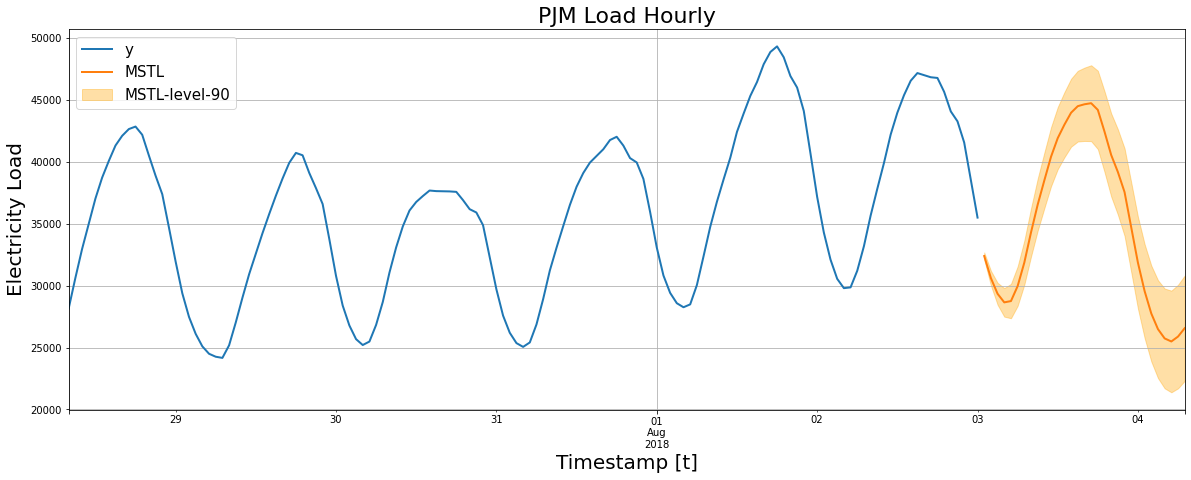

In [15]:
_, ax = plt.subplots(1, 1, figsize = (20, 7))
df_plot = pd.concat([df, forecasts]).set_index('ds').tail(24 * 7)
df_plot[['y', 'MSTL']].plot(ax=ax, linewidth=2)
ax.fill_between(df_plot.index, 
                df_plot['MSTL-lo-90'], 
                df_plot['MSTL-hi-90'],
                alpha=.35,
                color='orange',
                label='MSTL-level-90')
ax.set_title('PJM Load Hourly', fontsize=22)
ax.set_ylabel('Electricity Load', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()